In [1]:
import random
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [18]:
class Team:
    def __init__(self, founder):
        self.founder = founder
        self.members = {founder}
        self.a = random.uniform(0, 0.5)
        self.b = random.uniform(0.75, 1.25)
        self.beta = random.uniform(1.5, 2)

    def output(self, effort, total_effort_prev):
        total_effort = total_effort_prev + effort
        return self.a * total_effort + self.b * total_effort ** self.beta

    def add_member(self, agent):
        self.members.add(agent)

    def remove_member(self, agent):
        self.members.remove(agent)

In [19]:
class Agent:

    def __init__(self, theta, omega, network, birth_period = -1):
        self.theta = theta
        self.omega = omega
        self.network = network
        self.team = None
        self.effort = 0
        self.utility = 0
        self.birth_period = birth_period

    def choose_effort(self, team, total_effort_prev):
        def utility(effort):
            leisure = self.omega - effort
            consumption = team.output(effort, total_effort_prev) / len(team.members) if team else 0
            return consumption ** self.theta * leisure ** (1 - self.theta)

        def negative_utility(effort):
            return -utility(effort)

        res = minimize(negative_utility, self.omega / 2, bounds=[(0, self.omega)])
        self.effort = res.x[0]
        self.utility = -res.fun

    def choose_team(self, teams):
        # Вычислить е* и U(е*) в текущей фирме
        if self.team is not None:
            self.choose_effort(self.team, sum(a.effort for a in self.team.members) if self.team else 0)
        current_utility = self.utility
        # Вычислить е* и U(е*) во вновь создаваемой фирме
        new_team = Team(self)
        self.choose_effort(new_team, 0)
        startup_utility = self.utility
        best_utility = max(current_utility, startup_utility)
        best_team = self.team if current_utility >= startup_utility else new_team

        # ДЛЯ каждой фирмы в социальной сети агента
        for friend in self.network:
            if friend.team and friend.team != self.team:
                # Вычислить е* и U(e*)
                self.choose_effort(friend.team, sum(a.effort for a in friend.team.members))
                if self.utility > best_utility:
                    best_utility = self.utility
                    best_team = friend.team

        # ЕСЛИ текущая фирма - не лучший вариант, покинуть ее
        if self.team != best_team:
            if self.team:
                #print(f"I leave team. Team size {len(self.team.members)}")
                self.team.remove_member(self)
                #print(f"Team size now {len(self.team.members)}")
                if not self.team.members:
                    del teams[self.team]
                    #print("Team deleted")

        # ЕСЛИ стартап - лучший вариант: создать стартап
        if best_team == new_team:
            teams[new_team] = new_team
            best_team.add_member(self)

        # ЕСЛИ другая фирма - лучший вариант: присоединиться
        if best_team != new_team and best_team != self.team:
            best_team.add_member(self)

        self.team = best_team

In [20]:
def print_stats(name, data):
    print(f"{name} - Среднее: {np.mean(data):.2f}, Медиана: {np.median(data):.2f}, Мин: {np.min(data):.2f}, Макс: {np.max(data):.2f}")

def plot_distributions(*data, titles=None):
    num_plots = len(data)
    fig, axs = plt.subplots(2, 3, figsize=(12, 8))
    axs = axs.flatten()

    for i in range(num_plots):
        axs[i].hist(data[i], bins=20)
        if titles:
            axs[i].set_title(titles[i])
        axs[i].set_xlabel('Значение')
        axs[i].set_ylabel('Частота')

    plt.tight_layout()
    plt.show()

def plot_scatter(x, y, xlabel, ylabel, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(x, y)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

def analyze_period(agents, teams, period, job_changes):
    # Характеристики распределения отдельных показателей
    efforts = [agent.effort for agent in agents]
    output = [agent.team.output(agent.effort, sum(a.effort for a in agent.team.members)) if agent.team else 0 for agent in agents]
    income = [out / len(agent.team.members) if agent.team else 0 for out, agent in zip(output, agents)]
    utility = [agent.utility for agent in agents]
    team_sizes = [len(agent.team.members) if agent.team else 0 for agent in agents]
    team_ages = [period - agent.team.founder.birth_period if agent.team else 0 for agent in agents]

    # Вывод основных характеристик
    print(f"_________________________________________________________________________________")
    print(f"Период: {period}")
    print_stats("Усилия", efforts)
    print_stats("Выпуск", output)
    print_stats("Доход", income)
    print_stats("Полезность", utility)
    print_stats("Размер команды", team_sizes)
    print_stats("Возраст команды", team_ages)

    print(f"Количество агентов: {len(agents)}")
    print(f"Количество команд: {len(teams)}")
    print(f"Средние усилия: {np.mean(efforts):.2f}")
    print(f"Средний выпуск: {np.mean(output):.2f}")
    print(f"Средний доход: {np.mean(income):.2f}")
    print(f"Средняя полезность: {np.mean(utility):.2f}")
    print(f"Количество смен работы: {job_changes}")

    # Гистограммы распределений
    plot_distributions(efforts, output, income, utility, team_sizes, team_ages,
                       titles=["Распределение усилий", "Распределение выпуска", "Распределение дохода",
                               "Распределение полезности", "Распределение размера команды", "Распределение возраста команды"])

    # Взаимосвязь показателей
    plot_scatter(team_ages, team_sizes, "Возраст команды", "Размер команды", "Размер команды vs Возраст команды")

    growth_rates = [len(agent.team.members) / (period - agent.team.founder.birth_period) \
                    if agent.team and period != agent.team.founder.birth_period else 0 for agent in agents]
    plot_scatter(team_ages, growth_rates, "Возраст команды", "Темп роста", "Темп роста vs Возраст команды")

    # Распределения для фирм
    team_output = [sum(agent.effort for agent in team.members) for team in teams.values()]
    team_sizes = [len(team.members) for team in teams.values()]
    team_ages = [period - team.founder.birth_period for team in teams.values()]
    team_productivity = [out / size for out, size in zip(team_output, team_sizes)]
    team_growth_rates = [len(team.members) / (period - team.founder.birth_period) \
                         if period != team.founder.birth_period else 0 for team in teams.values()]

    print(f"\nРаспределения для фирм:")
    print_stats("Выпуск", team_output)
    print_stats("Размер", team_sizes)
    print_stats("Возраст", team_ages)
    print_stats("Производительность", team_productivity)
    print_stats("Темп роста", team_growth_rates)

    # Распределения для агентов
    agent_income = [agent.team.output(agent.effort, sum(a.effort if agent.team else 0 for a in agent.team.members)) / len(agent.team.members) \
                    if agent.team else 0 for agent in agents]
    agent_tenure = [period - agent.birth_period for agent in agents]
    agent_effort = [agent.effort for agent in agents]
    agent_utility = [agent.utility for agent in agents]
    agent_network_size = [len(agent.network) for agent in agents]

    print(f"\nРаспределения для агентов:")
    print_stats("Доход", agent_income)
    print_stats("Стаж", agent_tenure)
    print_stats("Усилия", agent_effort)
    print_stats("Полезность", agent_utility)
    print_stats("Размер сети", agent_network_size)

    # Гистограммы распределений для фирм
    plot_distributions(team_output, team_sizes, team_ages, team_productivity, team_growth_rates,
                       titles=["Распределение выпуска фирм", "Распределение размера фирм", "Распределение возраста фирм",
                               "Распределение производительности фирм", "Распределение темпов роста фирм"])

    # Гистограммы распределений для агентов
    plot_distributions(agent_income, agent_tenure, agent_effort, agent_utility, agent_network_size,
                       titles=["Распределение дохода агентов", "Распределение стажа агентов", "Распределение усилий агентов",
                               "Распределение полезности агентов", "Распределение размера сети агентов"])

In [21]:
def simulate(num_agents, num_periods, agent_id, team_id, is_anylize = False, is_anylize_total = True):
    agents = [Agent(random.uniform(0, 1), 1, set(), agent_id) for _ in range(num_agents)]
    
    for agent in agents:
        num_friends = random.randint(2, 6)
        agent.network = set(random.sample(agents, num_friends))

    teams = {}

    total_efforts = []
    total_output = []
    total_income = []
    total_utility = []
    job_changes = 0

    for period in range(num_periods):
        active_agents = random.sample(agents, int(num_agents * 0.04))
        for agent in active_agents:
            if agent.birth_period == -1:
                agent.birth_period = period
            old_team = agent.team
            agent.choose_team(teams)
            if agent.team != old_team:
                job_changes += 1
        # ДЛЯ каждой фирмы
        for team in teams.values():
            # Сложить усилия агентов, произвести продукцию
            total_effort = sum(agent.effort for agent in team.members)
            output = team.output(total_effort, total_effort)

            # Разделить продукцию
            income = output / len(team.members)
            for agent in team.members:
                agent.utility = income ** agent.theta * (agent.omega - agent.effort) ** (1 - agent.theta)
        efforts = [agent.effort for agent in agents]
        output = [agent.team.output(agent.effort, sum(a.effort for a in agent.team.members)) if agent.team else 0 for agent in agents]
        income = [out / len(agent.team.members) if agent.team else 0 for out, agent in zip(output, agents)]
        utility = [agent.utility for agent in agents]

        total_efforts.append(np.mean(efforts))
        total_output.append(np.mean(output))
        total_income.append(np.mean(income))
        total_utility.append(np.mean(utility))

        for team in list(teams.keys()):
            if not team.members:
                del teams[team]

        # Анализ текущего периода
        if is_anylize:
            analyze_period(agents, teams, period, job_changes)
        
    if is_anylize_total:
        analyze_period(agents, teams, period, job_changes)
    return agents, teams, total_efforts, total_output, total_income, total_utility, job_changes

_________________________________________________________________________________
Период: 99
Усилия - Среднее: 0.36, Медиана: 0.27, Мин: 0.00, Макс: 1.00
Выпуск - Среднее: 85823.32, Медиана: 95157.04, Мин: 0.00, Макс: 95618.62
Доход - Среднее: 95.34, Медиана: 105.61, Мин: 0.00, Макс: 106.12
Полезность - Среднее: 52.68, Медиана: 11.60, Мин: 0.00, Макс: 408.97
Размер команды - Среднее: 812.13, Медиана: 901.00, Мин: 0.00, Макс: 901.00
Возраст команды - Среднее: 98.11, Медиана: 99.00, Мин: 0.00, Макс: 99.00
Количество агентов: 1000
Количество команд: 52
Средние усилия: 0.36
Средний выпуск: 85823.32
Средний доход: 95.34
Средняя полезность: 52.68
Количество смен работы: 2017


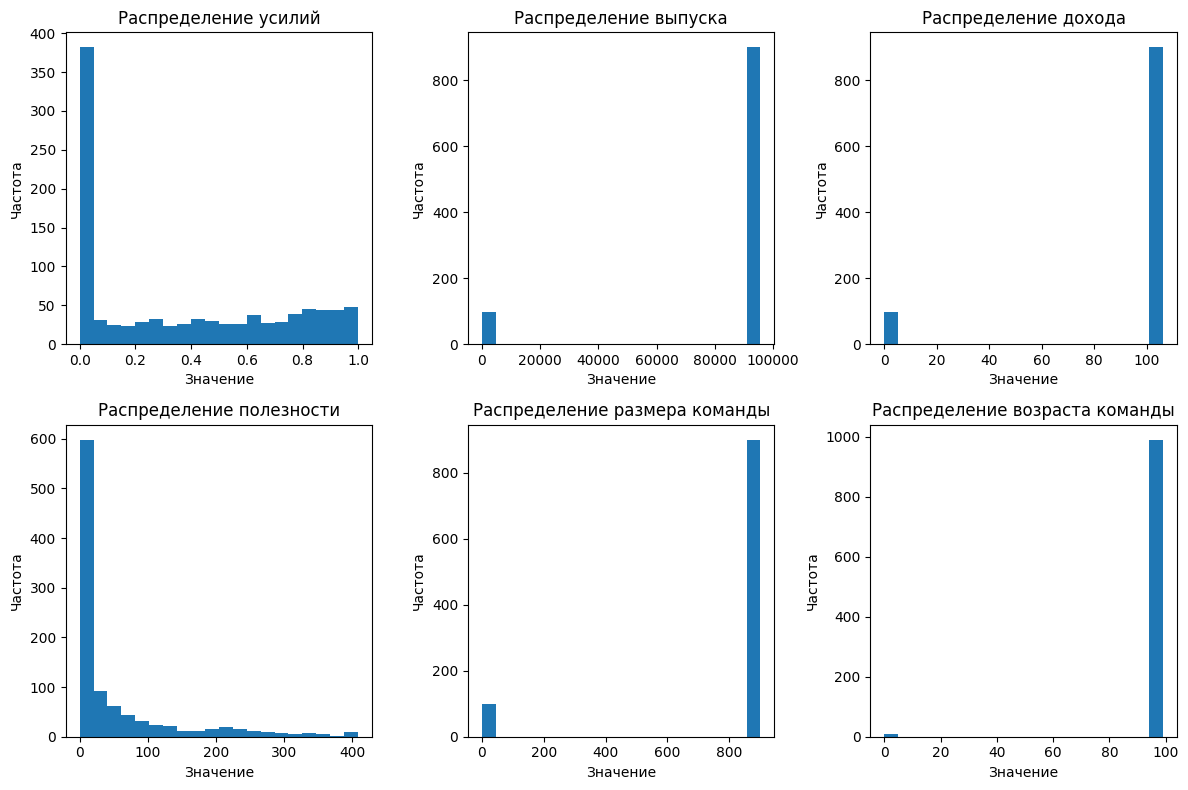

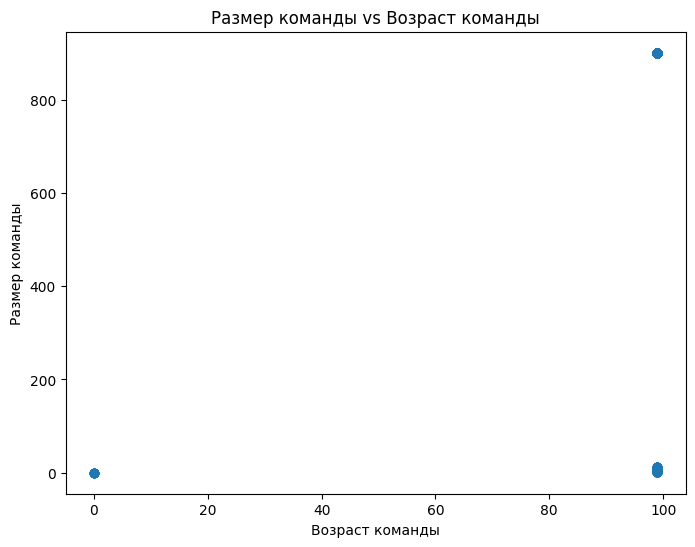

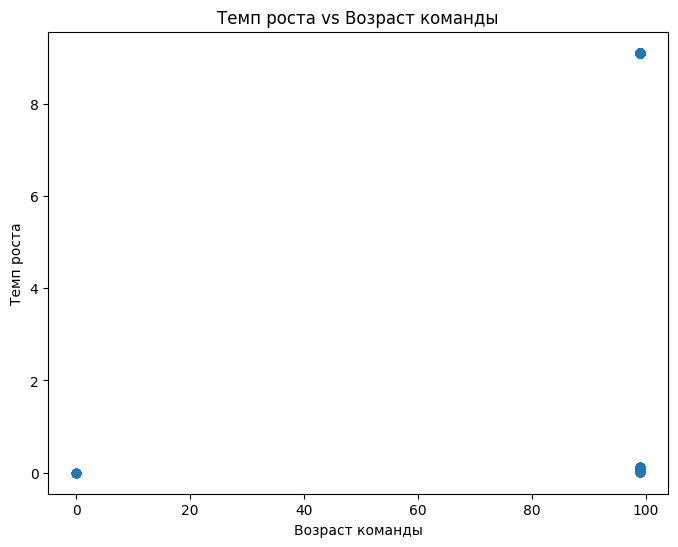


Распределения для фирм:
Выпуск - Среднее: 6.84, Медиана: 0.44, Мин: 0.00, Макс: 326.70
Размер - Среднее: 19.06, Медиана: 1.00, Мин: 1.00, Макс: 901.00
Возраст - Среднее: 99.00, Медиана: 99.00, Мин: 99.00, Макс: 99.00
Производительность - Среднее: 0.33, Медиана: 0.33, Мин: 0.00, Макс: 0.91
Темп роста - Среднее: 0.19, Медиана: 0.01, Мин: 0.01, Макс: 9.10

Распределения для агентов:
Доход - Среднее: 95.34, Медиана: 105.61, Мин: 0.00, Макс: 106.12
Стаж - Среднее: 99.00, Медиана: 99.00, Мин: 99.00, Макс: 99.00
Усилия - Среднее: 0.36, Медиана: 0.27, Мин: 0.00, Макс: 1.00
Полезность - Среднее: 52.68, Медиана: 11.60, Мин: 0.00, Макс: 408.97
Размер сети - Среднее: 4.02, Медиана: 4.00, Мин: 2.00, Макс: 6.00


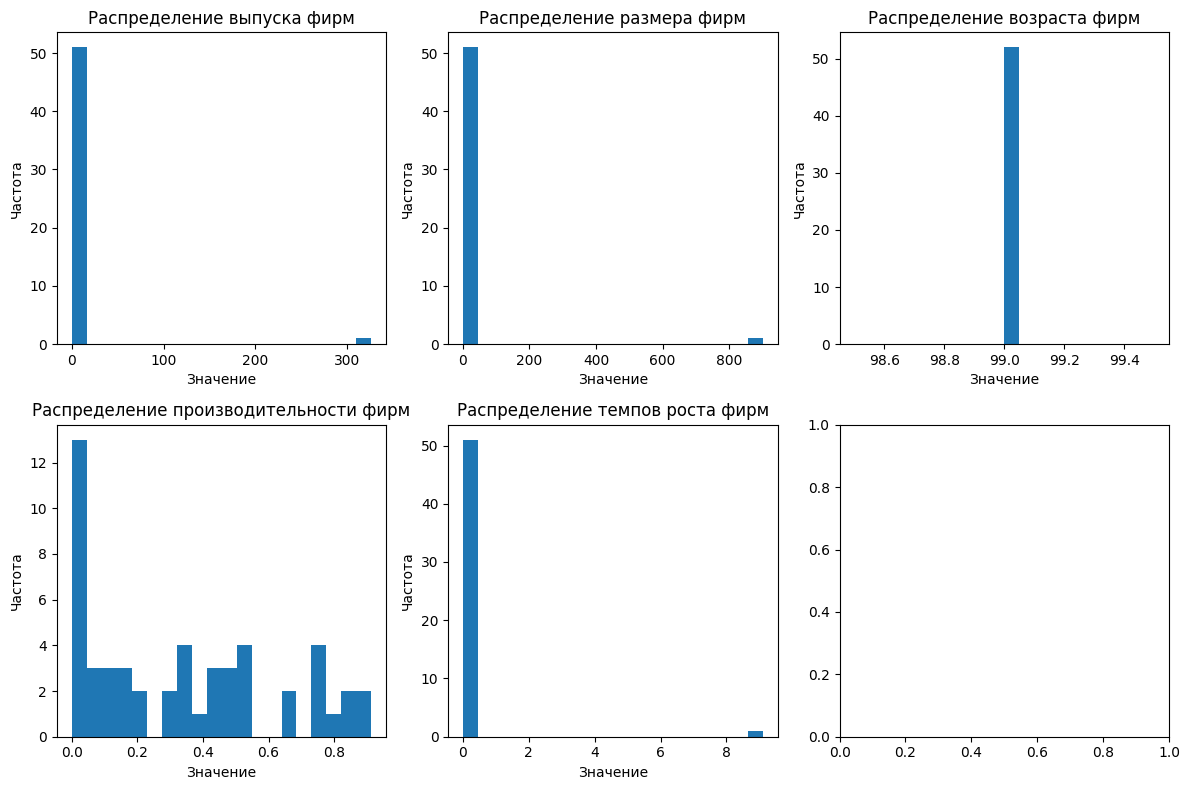

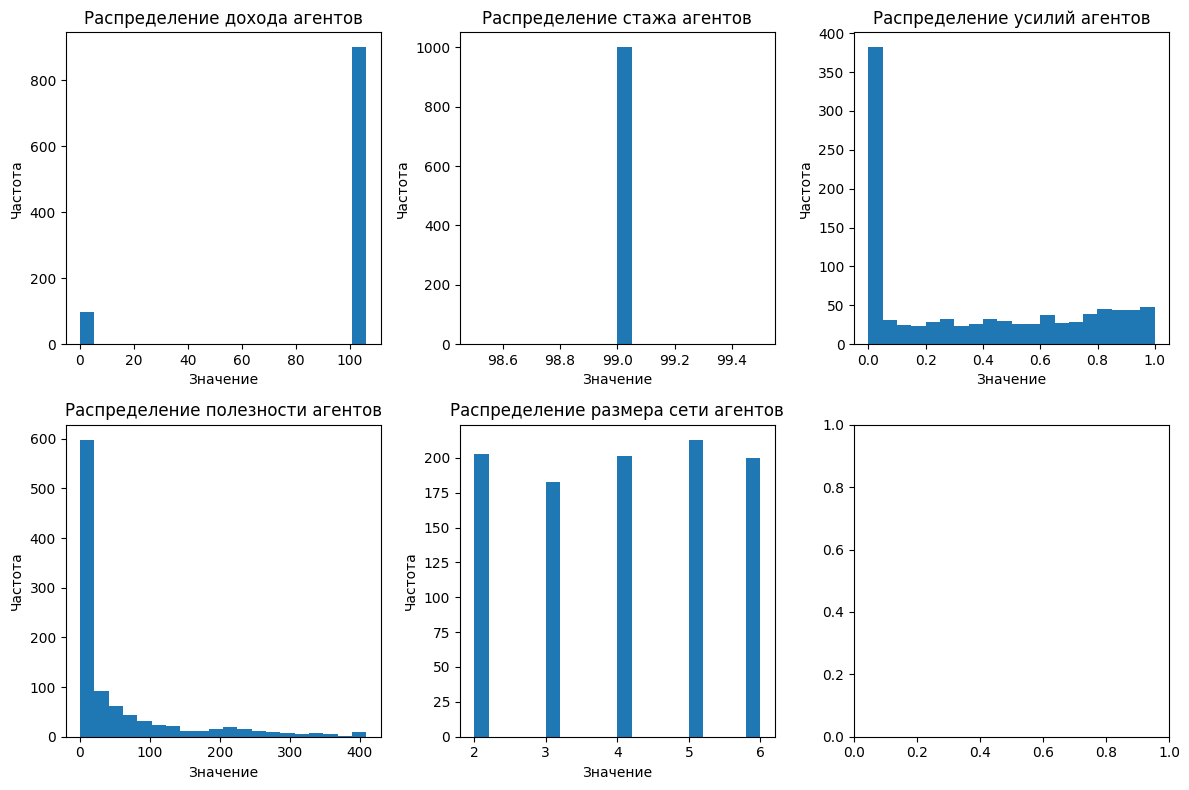

In [22]:
# Базовая конфигурация
num_agents = 1000
num_periods = 100  # Один модельный период = один календарный месяц
agent_id = 0
team_id = 0
agents, teams, efforts, output, income, utility, job_changes = \
    simulate(num_agents, num_periods, False, True)


In [23]:
members_sum = 0
for team in teams:
    if len(team.members) > 0:
        print(f'{len(team.members)}')
        members_sum+=len(team.members)
print(f"Total active members count:{members_sum}")

1
2
1
1
1
1
1
5
2
1
2
1
4
1
901
1
1
12
1
1
5
1
2
1
1
1
1
1
1
4
1
1
1
2
1
2
3
1
1
1
1
2
1
5
1
2
1
1
1
1
1
1
Total active members count:991


In [48]:
print(f'{len(teams)}')
print(f'{len(agents)}')

9
100
